<a href="https://colab.research.google.com/github/hiyer7/Data-Science-Projects/blob/main/LoanTap_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

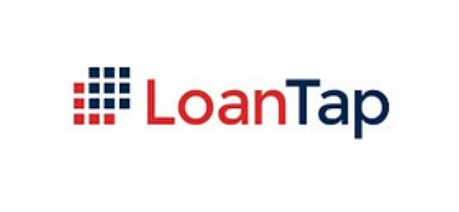

#1. Goal

The primary goal of this case study is to build a robust data-driven underwriting model that enables LoanTap to evaluate the creditworthiness of individuals applying for personal loans. The model should help the organization identify potential defaulters in advance, enabling risk-informed loan disbursement decisions, minimizing non-performing assets (NPAs), and maximizing returns.

##Objective


1. Understand Borrower Profiles
Perform comprehensive exploratory data analysis (EDA) to identify trends, patterns, and outliers in borrower attributes such as employment, income, debt-to-income ratio, loan purpose, credit history, etc.

2. Prepare High-Quality Input Data
Handle missing values, encode categorical variables, engineer new features (e.g., flags for public records), scale numerical attributes, and address class imbalance to ensure the dataset is suitable for modeling.

3. Develop a Predictive Classification Model
Use Logistic Regression to classify loan applicants as likely to repay or default on their loan. Evaluate the model using metrics like precision, recall, F1-score, and ROC AUC to understand its performance in identifying true defaulters.

4. Balance Business Risk vs. Growth
Explore different threshold values and evaluate trade-offs between false positives and false negatives to recommend risk strategies—from conservative to aggressive lending policies.

5. Generate Actionable Insights
Derive meaningful insights based on job titles, grades, income levels, and geographic distribution to identify riskier customer segments and recommend loan caps or stricter screening for those tiers.

6. Support Business Decision-Making
Translate technical model outputs into clear business recommendations that LoanTap’s underwriting and risk teams can act upon to streamline personal loan approvals.

##Library Imports

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

##Data Read

In [5]:
url = "https://drive.google.com/file/d/1ZPYj7CZCfxntE8p2Lze_4QO4MyEOy6_d/view?usp=drive_link"
file_id = url.split('/')[-2]
download_url = f"https://drive.google.com/uc?id={file_id}"
df = pd.read_csv(download_url)

In [6]:
df.head(1)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"


#2. EDA

In [7]:
df.shape

(396030, 27)

In [8]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'address'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

##Empty Columns

In [10]:
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_percent = missing_percent[missing_percent > 0]  # Optional: only show columns with missing values
missing_percent = missing_percent.round(2).sort_values(ascending=False)

print(missing_percent)


mort_acc                9.54
emp_title               5.79
emp_length              4.62
title                   0.44
pub_rec_bankruptcies    0.14
revol_util              0.07
dtype: float64


We will be imputing them later

##Unique

In [11]:
for col in df.columns:
  print(f"{col}: {df[col].nunique()}")


loan_amnt: 1397
term: 2
int_rate: 566
installment: 55706
grade: 7
sub_grade: 35
emp_title: 173105
emp_length: 11
home_ownership: 6
annual_inc: 27197
verification_status: 3
issue_d: 115
loan_status: 2
purpose: 14
title: 48816
dti: 4262
earliest_cr_line: 684
open_acc: 61
pub_rec: 20
revol_bal: 55622
revol_util: 1226
total_acc: 118
initial_list_status: 2
application_type: 3
mort_acc: 33
pub_rec_bankruptcies: 9
address: 393700


##Column wise interpretation

###sub-grade

In [12]:
df['sub_grade'].value_counts().count()

np.int64(35)

Since this has high cardinality and overlaps with the column grade, we will be dropping this

In [13]:
df.drop(columns='sub_grade', inplace= True)

###term

There are only two values in this.

We will convert these strings to numeric by retining only the numeric values

In [14]:
df['term'] = df['term'].str.extract('(\d+)').astype(int)

In [15]:
df['term'].astype

<bound method NDFrame.astype of 0         36
1         36
2         36
3         36
4         60
          ..
396025    60
396026    36
396027    36
396028    60
396029    36
Name: term, Length: 396030, dtype: int64>

In [16]:
df['term'].value_counts()

,count
term,
36,302005
60,94025


###Title and Purpose

In [17]:
df[['title', 'purpose']].head()

,title,purpose
0,Vacation,vacation
1,Debt consolidation,debt_consolidation
2,Credit card refinancing,credit_card
3,Credit card refinancing,credit_card
4,Credit Card Refinance,credit_card


 Both these columns have the same values with different columns names. We will be dropping title

In [18]:
df.drop(columns='title', inplace=True)

###Address

In [19]:
df['address'].value_counts()

,count
address,
USS Johnson\r\nFPO AE 48052,8
USNS Johnson\r\nFPO AE 05113,8
USS Smith\r\nFPO AP 70466,8
USCGC Smith\r\nFPO AE 70466,8
USNS Johnson\r\nFPO AP 48052,7
...,...
"8141 Cox Greens Suite 186\r\nMadisonstad, VT 05113",1
"8803 Sean Highway Suite 029\r\nNorth Nicoleshire, AK 11650",1
"594 Nicole Mission Apt. 620\r\nNew Patrick, NJ 00813",1


In [20]:
df['zip_code']= df['address'].str.extract(r'(\d{5})$')
#df['zip_code'].value_counts().count()
df['zip_code'] = pd.to_numeric(df['zip_code'], errors='coerce')  # converts invalid to NaN
df['zip_code'] = df['zip_code'].astype(int)

In [21]:
df['zip_code'].nunique()

10

In [22]:
#df['state']= df['address'].str.extract(r'([A-Z]{2})\s\d{5}$')
#df['state'].value_counts().count()

Now that we have extracted useful info from the address colun, we will be dropping it

In [23]:
df.drop(columns='address', inplace=True)

In [24]:
df['emp_title']

,emp_title
0,Marketing
1,Credit analyst
2,Statistician
3,Client Advocate
4,Destiny Management Inc.
...,...
396025,licensed bankere
396026,Agent
396027,City Carrier
396028,"Gracon Services, Inc"


###emp_title

emp_title has about 6% null values. We will be only keeping the top ten titles and grouping all others under 'other' category

In [25]:
top_ten_titles= df['emp_title'].value_counts().nlargest(10).index

df['emp_title_grouped']= df['emp_title'].apply(lambda x: x if x in top_ten_titles else 'other')
df['emp_title_grouped'].value_counts()

,count
emp_title_grouped,
other,374749
Teacher,4389
Manager,4250
Registered Nurse,1856
RN,1846
Supervisor,1830
Sales,1638
Project Manager,1505
Owner,1410


In [26]:
df.drop(columns= 'emp_title', inplace= True)

###mort_acc

mort_acc has about 10% null values

We'll be imputing mort_acc using the median mort_acc per group of total_acc.

This makes sense because users with similar total_acc (total number of credit lines) are likely to have similar mortgage profiles.

In [27]:
mort_acc_medians= df.groupby('total_acc')['mort_acc'].median()#.reset_index().sort_values(by='mort_acc')#, descending=True)

def impute_mort_acc(row):
  if pd.isnull(row['mort_acc']):
    return mort_acc_medians.get(row['total_acc'], df['mort_acc'].median())
  else:
    return row['mort_acc']

df['mort_acc']= df.apply(impute_mort_acc, axis= 1)

df['mort_acc'].isna().sum()

np.int64(0)

There no null values anymore

In [28]:
df[['mort_acc', 'total_acc']].corr()

,mort_acc,total_acc
mort_acc,1.00000,0.40569
total_acc,0.40569,1.00000


There's low correlation between these two columns. Retaining both will be essential for now

###pub_rec_bankruptcies

In [29]:
df['pub_rec_bankruptcies'].value_counts()

,count
pub_rec_bankruptcies,
0.0,350380
1.0,42790
2.0,1847
3.0,351
4.0,82
5.0,32
6.0,7
7.0,4
8.0,2


In [30]:
(df['pub_rec_bankruptcies'].isna().sum()/len(df))*100

np.float64(0.13509077595131683)

In [31]:
pub_rec_bankruptcies_mode_value= df['pub_rec_bankruptcies'].mode()[0]
#pub_rec_bankruptcies_mode_value

df['pub_rec_bankruptcies']= df['pub_rec_bankruptcies'].fillna(pub_rec_bankruptcies_mode_value)
df['pub_rec_bankruptcies'].isna().sum()

np.int64(0)

###emp_length

In [32]:
df['emp_length'].value_counts()

,count
emp_length,
10+ years,126041
2 years,35827
< 1 year,31725
3 years,31665
5 years,26495
1 year,25882
4 years,23952
6 years,20841
7 years,20819


####Converting the string values to numeric

In [33]:
def convert_emp_length(val):
    if pd.isnull(val):
        return np.nan
    elif val == '10+ years':
        return 10
    elif val == '< 1 year':
        return 0
    else:
        return int(val.strip().split()[0])  # e.g., "2 years" -> 2

df['emp_length_num'] = df['emp_length'].apply(convert_emp_length)


In [34]:
df['emp_length_num'].value_counts()

,count
emp_length_num,
10.0,126041
2.0,35827
0.0,31725
3.0,31665
5.0,26495
1.0,25882
4.0,23952
6.0,20841
7.0,20819


####Imputing the missing rows with median

In [35]:
emp_length_mode = df['emp_length_num'].median()
df['emp_length_num'] = df['emp_length_num'].fillna(emp_length_mode)


In [36]:
df['emp_length_num'].isna().sum()

np.int64(0)

In [37]:
df.drop(columns='emp_length', inplace=True)

###revol_util

Revolving utilization rate: how much credit a person is using relative to their total revolving credit.

Important financial signal — high values can indicate credit stress, so it’s useful for modeling default risk.

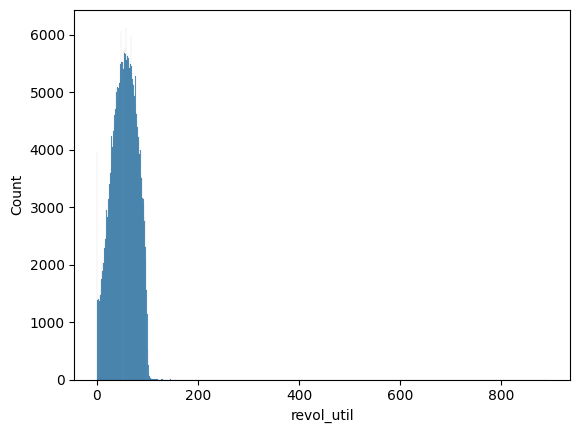

In [38]:
sns.histplot(x=df['revol_util'])
plt.show()

The bulk of the data is clustered between 0 and ~150, with a peak around 30–40.

There's a long tail and a few significant outliers (some values >800).

Overall, it shows a right-skewed distribution — not exactly normal, but fairly consistent with typical utilization rate distributions in credit datasets.

In [39]:
revol_util_median = df['revol_util'].median()
df['revol_util']= df['revol_util'].fillna(revol_util_median)


In [40]:
df['revol_util'].isna().sum()

np.int64(0)

Median is robust to outliers (e.g., if some people have 100% utilization).

This preserves the structure of your dataset and avoids distortion.

###We will come back to dealing with columns at  later stage when we



1.   Check for outliers
2.   Feature selection
3.   Checking for collinearity between the features



##Univariate Analysis

Continuous: loan_amnt, int_rate, installment, annual_inc, dti, revol_bal

Categorical: grade, home_ownership, verification_status, purpose, loan_status

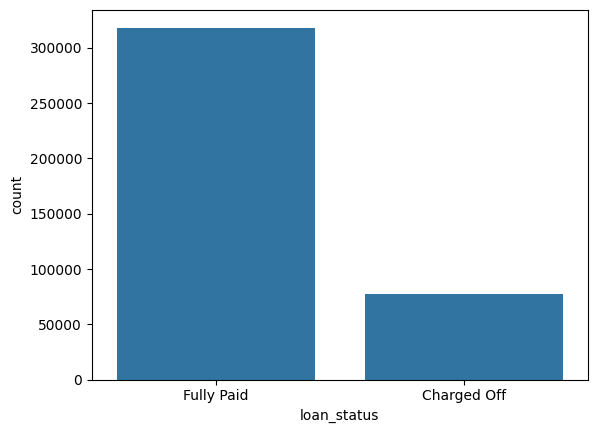

In [41]:
sns.countplot(x= 'loan_status', data= df)
plt.show()

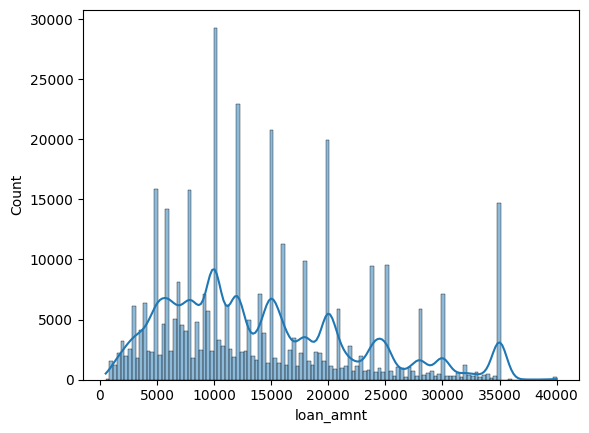

In [42]:
sns.histplot(df['loan_amnt'], kde= True)
plt.show()

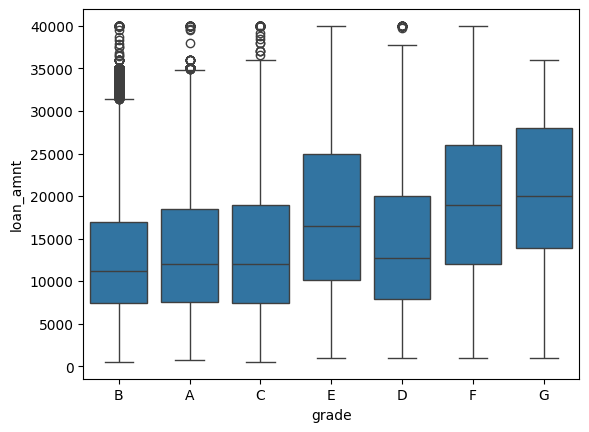

In [43]:
sns.boxplot(x= 'grade', y= 'loan_amnt', data= df)
plt.show()

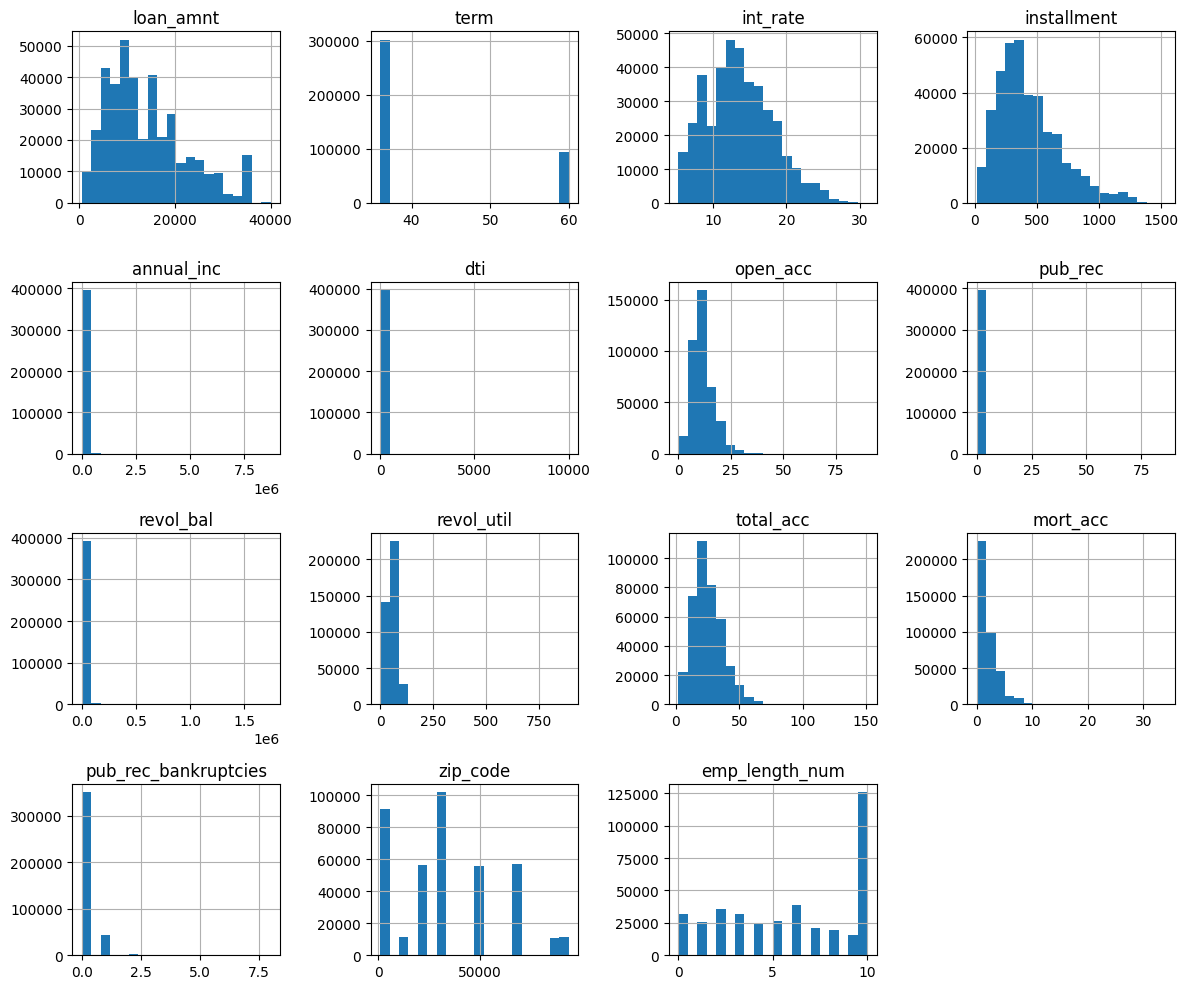

In [44]:
df.hist(figsize=(12,10), bins=20)
plt.tight_layout()
plt.show()

| Column                     | Issues Detected              | Comments & Suggested Treatment                                                                         |
| -------------------------- | ---------------------------- | ------------------------------------------------------------------------------------------------------ |
| **loan\_amnt**             | ✔ High cardinality, no nulls | Check for negative/zero values or outliers. Distribution analysis recommended.                         |
| **term**                   | ✔ Only 2 unique values       | Convert to numeric (36, 60). Check for leading/trailing whitespaces.                                   |
| **int\_rate**              | ✔ 566 unique values          | No nulls. Check for outliers, and scale if needed.                                                     |
| **installment**            | ✔ 55K+ unique values         | Correlated with `loan_amnt`. Investigate multicollinearity. Scale if used in model.                    |
| **grade**                  | ✔ 7 values (A–G)             | Ordinal – map A→1, B→2, etc.                                                                           |
| **sub\_grade**             | ✔ 35 values (A1–G5)          | Can be derived from grade; can encode as ordinal or one-hot.                                           |
| **emp\_title**             | ❗ 22,927 nulls, 173K unique  | Text column, too high cardinality. Consider dropping or grouping by frequency (e.g., top 10 titles).   |
| **emp\_length**            | ❗ 18,301 nulls, 11 values    | Clean values ("10+ years", "<1 year", "n/a"), convert to numeric. Impute missing with mode or unknown. |
| **home\_ownership**        | ✔ 6 values                   | One-hot or ordinal encode. Validate for odd categories (e.g., "ANY").                                  |
| **annual\_inc**            | ✔ 0 nulls, 27K unique        | Check for outliers (e.g., income > 10 million), log transform if skewed.                               |
| **verification\_status**   | ✔ 3 categories               | One-hot encode.                                                                                        |
| **issue\_d**               | ✔ 115 unique months          | Convert to datetime, then extract year/month if needed.                                                |
| **loan\_status**           | ✔ Target column              | Only 2 values → convert to binary: Fully Paid = 1, Charged Off = 0                                     |
| **purpose**                | ✔ 14 categories              | One-hot encode. Group rare ones into "Other" if needed.                                                |
| **title**                  | ❗ 1,756 nulls, 48K unique    | Text data; likely similar to `purpose`. Drop if redundant or use only top titles.                      |
| **dti**                    | ✔ 0 nulls                    | Check for high values >50 (indicates high debt). Treat outliers.                                       |
| **earliest\_cr\_line**     | ✔ 684 values                 | Convert to datetime. Extract year for credit history length.                                           |
| **open\_acc**              | ✔ No nulls, 61 unique        | Check if >50; may be unrealistic.                                                                      |
| **pub\_rec**               | ✔ Mostly 0s                  | Flag as binary: pub\_rec\_flag = 1 if > 0 else 0                                                       |
| **revol\_bal**             | ✔ High variance              | No nulls, scale or log-transform                                                                       |
| **revol\_util**            | ❗ 276 nulls                  | Impute using median or based on `revol_bal` group. Cap values at 100%                                  |
| **total\_acc**             | ✔ No issues                  | Standardize or scale if required                                                                       |
| **initial\_list\_status**  | ✔ 2 values                   | Encode as binary                                                                                       |
| **application\_type**      | ✔ 3 values                   | Mostly "Individual", check for imbalance                                                               |
| **mort\_acc**              | ❗ 37,795 nulls               | Impute with median or group median by `total_acc` or `open_acc`                                        |
| **pub\_rec\_bankruptcies** | ❗ 535 nulls                  | Create flag: bankruptcy\_flag. Impute missing as 0 or mode                                             |
| **address**                | ✔ 393,700 unique             | Very high cardinality, use only derived feature like zip code if required. Else drop.                  |


##Bivariate Analysis

###Correlation Matrix

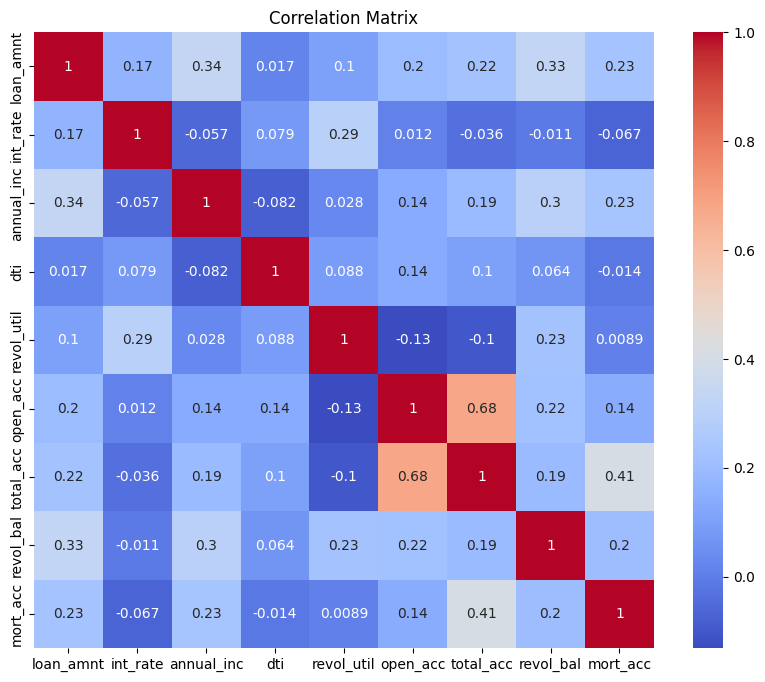

In [45]:
continuous_col= [
    'loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_util',
    'open_acc', 'total_acc', 'revol_bal', 'mort_acc'
]

plt.figure(figsize=(10,8))
sns.heatmap(data=df[continuous_col].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

###Dwelving on installment vs loan_amnt

We see a collinear relationship between the two columns
Since installment is derived from loan_amnt, int_rate, and term, it can introduce multicollinearity in regression models.

So, we'll drop the installment column from the df, prefered keeping loan_amnt for interpretability, especially in a business context.

In [46]:
df.drop(columns= 'installment', inplace=True)

###Pairplot

In [47]:
#sns.pairplot(df)
#plt.show()

###EDA Insights

In [48]:
df['loan_status'].value_counts()

,count
loan_status,
Fully Paid,318357
Charged Off,77673


Likely Influential Features for Loan Repayment (loan_status)

| Feature                                   | Why It Might Matter                                                                                                     |
| ----------------------------------------- | ----------------------------------------------------------------------------------------------------------------------- |
| **int\_rate** (interest rate)             | Higher interest → harder to repay. Often used for risk-based pricing.                                                   |
| **annual\_inc** (income)                  | Lower income → higher repayment stress. Strong indicator of repayment capacity.                                         |
| **dti** (debt-to-income ratio)            | Higher DTI means more debt burden. Strong predictor of financial stress.                                                |
| **emp\_length**                           | More stable employment history → less likely to default.                                                                |
| **home\_ownership**                       | Owning a home (vs renting) may indicate financial stability.                                                            |
| **pub\_rec** / **pub\_rec\_bankruptcies** | Past delinquencies or bankruptcies signal credit risk.                                                                  |
| **revol\_util**                           | High utilization of revolving credit → potential cash flow stress.                                                      |
| **grade** / **sub\_grade**                | Internal credit rating by LoanTap — probably derived from model predictions or credit bureau scores. Highly predictive. |
| **verification\_status**                  | Verified income → more trustworthy borrower.                                                                            |
| **loan\_amnt**                            | Larger loan amounts → higher monthly burden → more risk, especially if income is not high.                              |
| **term**                                  | 60-month loans may have more defaults than 36-month loans, depending on loan fatigue.                                   |
| **purpose**                               | Reason for loan — e.g., "medical" or "debt\_consolidation" may signal higher financial distress.                        |
| **application\_type**                     | Individual vs Joint — joint apps may be safer.                                                                          |
| **open\_acc / total\_acc / mort\_acc**    | Overall credit health.                                                                                                  |
| **state / zip\_code** (from `address`)    | Repayment rates may vary by region due to economic conditions.                                                          |


##Outlier Treatment

In [49]:
continuous_col = [
    'loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_util',
    'open_acc', 'total_acc', 'revol_bal', 'mort_acc'
]


In [50]:
df.describe()

,loan_amnt,term,int_rate,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,zip_code,emp_length_num
count,396030.000000,396030.000000,396030.000000,3.960300e+05,396030.000000,396030.000000,396030.000000,3.960300e+05,396030.000000,396030.000000,396030.000000,396030.000000,396030.000000,396030.000000
mean,14113.888089,41.698053,13.639400,7.420318e+04,17.379514,11.311153,0.178191,1.584454e+04,53.792451,25.414744,1.741384,0.121483,33998.447686,5.941416
std,8357.441341,10.212038,4.472157,6.163762e+04,18.019092,5.137649,0.530671,2.059184e+04,24.443685,11.886991,2.076183,0.355962,25605.865779,3.560415
min,500.000000,36.000000,5.320000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000,813.000000,0.000000
25%,8000.000000,36.000000,10.490000,4.500000e+04,11.280000,8.000000,0.000000,6.025000e+03,35.900000,17.000000,0.000000,0.000000,11650.000000,3.000000
50%,12000.000000,36.000000,13.330000,6.400000e+04,16.910000,10.000000,0.000000,1.118100e+04,54.800000,24.000000,1.000000,0.000000,29597.000000,6.000000
75%,20000.000000,36.000000,16.490000,9.000000e+04,22.980000,14.000000,0.000000,1.962000e+04,72.900000,32.000000,3.000000,0.000000,48052.000000,10.000000
max,40000.000000,60.000000,30.990000,8.706582e+06,9999.000000,90.000000,86.000000,1.743266e+06,892.300000,151.000000,34.000000,8.000000,93700.000000,10.000000


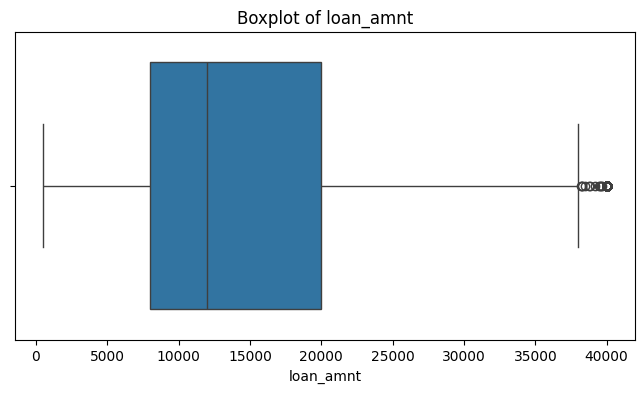

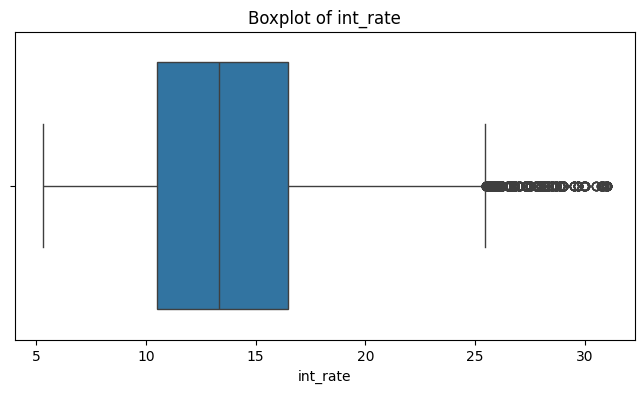

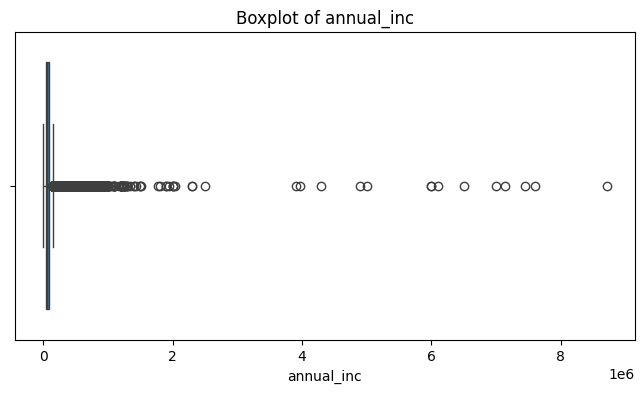

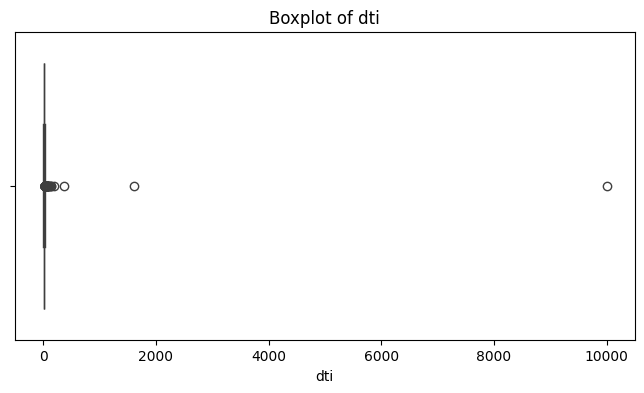

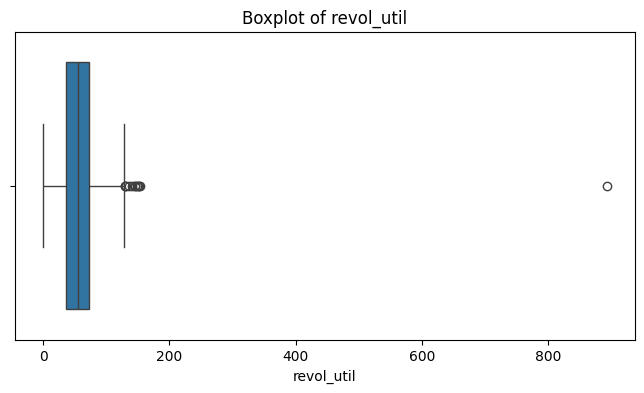

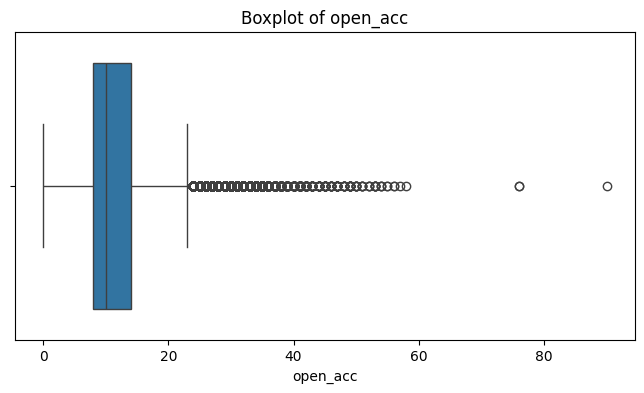

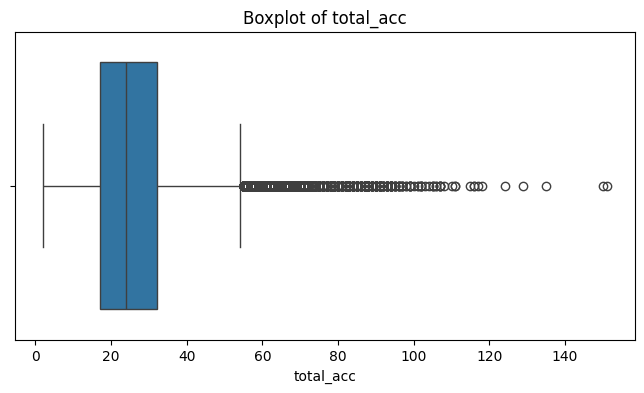

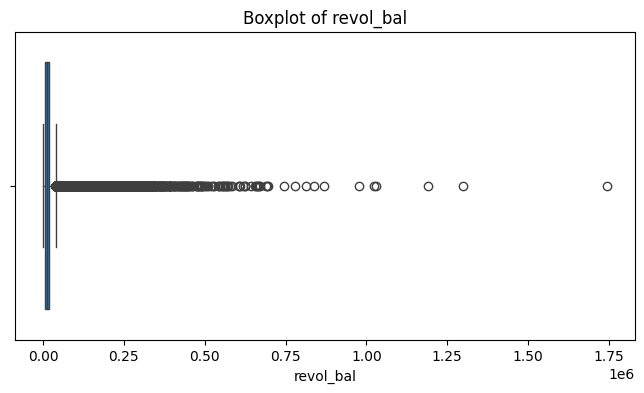

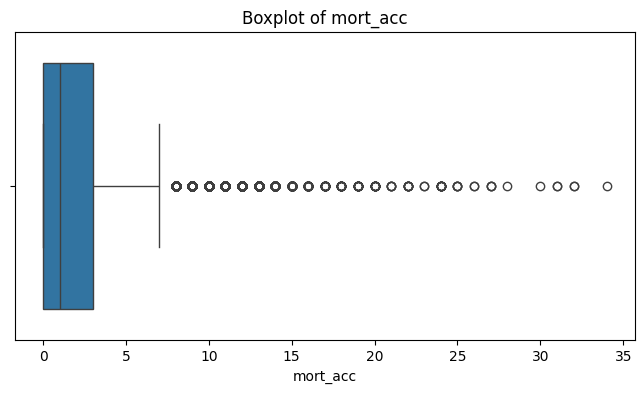

In [51]:

for col in continuous_col:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


We will cap the outliers using the IQR Capping method

In [52]:
def cap_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[column] = np.where(df[column] < lower, lower,
                  np.where(df[column] > upper, upper, df[column]))
    return df

# Apply to all numeric columns
for col in continuous_col:
    df = cap_outliers(df, col)

In [53]:
df[continuous_col].describe()

,loan_amnt,int_rate,annual_inc,dti,revol_util,open_acc,total_acc,revol_bal,mort_acc
count,396030.000000,396030.000000,396030.000000,396030.000000,396030.000000,396030.000000,396030.000000,396030.000000,396030.000000
mean,14112.952996,13.631040,70989.511539,17.344383,53.790139,11.188910,25.260274,14168.187719,1.709171
std,8354.657529,4.447901,34320.591396,8.114584,24.406309,4.736931,11.401037,10709.376921,1.948261
min,500.000000,5.320000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
25%,8000.000000,10.490000,45000.000000,11.280000,35.900000,8.000000,17.000000,6025.000000,0.000000
50%,12000.000000,13.330000,64000.000000,16.910000,54.800000,10.000000,24.000000,11181.000000,1.000000
75%,20000.000000,16.490000,90000.000000,22.980000,72.900000,14.000000,32.000000,19620.000000,3.000000
max,38000.000000,25.490000,157500.000000,40.530000,128.400000,23.000000,54.500000,40012.500000,7.500000


#3. Data Preprocessing

##Feature Engineering

Goals of Feature Engineering:

1. Simplify or enhance existing features.
2. Create new variables that capture hidden patterns.
3. Handle skewed categories or irrelevant noise.

####Converting to numeric

We have already converted
1. term
2. emp_length
3. emp_title
4. Extracted address into zip and state


####Creating Flags as binary indicators

In [54]:
df['has_pub_rec'] = (df['pub_rec'] > 0).astype(int)
df['has_mort_acc'] = (df['mort_acc'] > 0).astype(int)
df['has_bankruptcy'] = (df['pub_rec_bankruptcies'] > 0).astype(int)

In [55]:
df.drop(['pub_rec', 'mort_acc', 'pub_rec_bankruptcies'], axis=1, inplace=True)

These flags will help the model distinguish risky borrowers cleanly.


####Converting the date time columns

In [56]:
# Ensure dates are in datetime format
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])

# Compute credit age in months (approximate using year + month difference)
df['credit_age_months'] = (df['issue_d'].dt.year - df['earliest_cr_line'].dt.year) * 12 + \
                          (df['issue_d'].dt.month - df['earliest_cr_line'].dt.month)

df['issue_year'] = df['issue_d'].dt.year
df['issue_month'] = df['issue_d'].dt.month



We will drop the earliest_cr_line column since we have extracted relevant data from it

In [57]:
df.drop(['issue_d', 'earliest_cr_line'], axis=1, inplace=True)

#df.drop(columns='issue_d', inplace= True)

####Log Transforming annual_inc

<Axes: xlabel='annual_inc', ylabel='Count'>

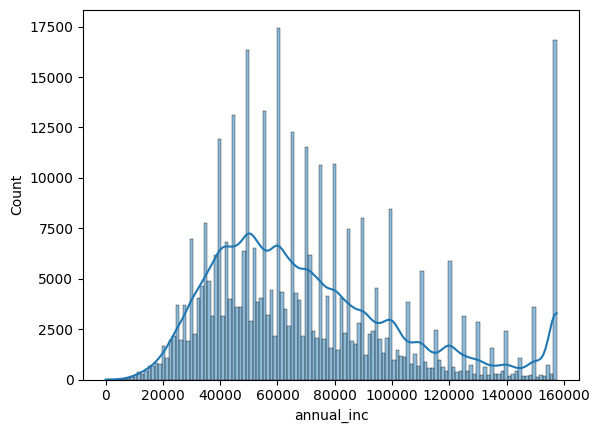

In [58]:
sns.histplot(df['annual_inc'], kde=True)

<Axes: xlabel='log_annual_inc', ylabel='Count'>

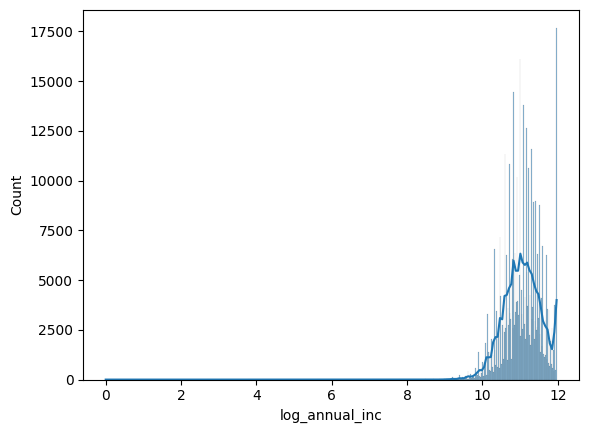

In [59]:
df['log_annual_inc'] = np.log1p(df['annual_inc'])

sns.histplot(df['log_annual_inc'], kde=True)

We have log transformed it so that this handles skewness and outliers, and is still a continuous numeric feature, so no need to encode.

In [60]:
df.drop(columns='annual_inc', inplace= True)


####Encoding

#####One hot encoding on

In [61]:
df = pd.get_dummies(df, columns=['home_ownership',
                                 'purpose', 'application_type', 'initial_list_status','verification_status','emp_title_grouped'], drop_first=True)


#####Label Encoding on grade

In [62]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['grade'] = le.fit_transform(df['grade'])  # A=0, B=1, etc.

#####Frequency Encoding on zip-code

In [63]:
freq_map = df['zip_code'].value_counts().to_dict()
df['zip_code_freq'] = df['zip_code'].map(freq_map)

In [64]:
df.drop(columns='zip_code', inplace= True)

####Handling our target: loan_status

In [65]:
df['loan_status'].value_counts()

,count
loan_status,
Fully Paid,318357
Charged Off,77673


Converting the values to binary

In [66]:
df['loan_status_bin'] = df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})

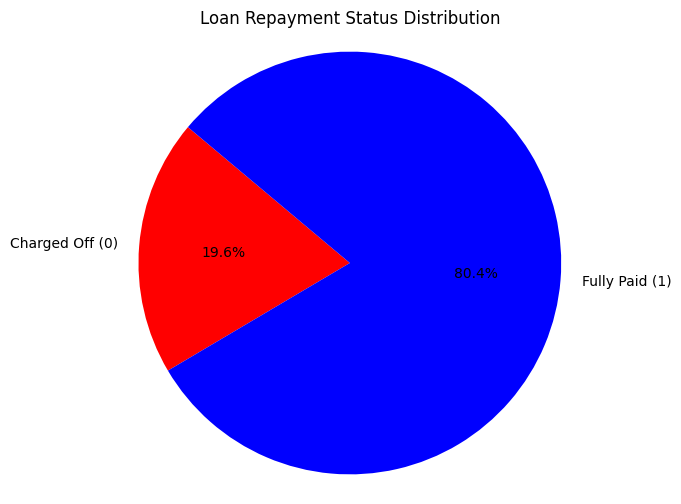

In [67]:
import matplotlib.pyplot as plt

# Get counts of 0 and 1
labels = ['Charged Off (0)', 'Fully Paid (1)']
sizes = df['loan_status_bin'].value_counts().sort_index()

# Optional: add colors
colors = ['red','blue']

# Create pie chart
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Loan Repayment Status Distribution')
plt.axis('equal')  # Equal aspect ratio ensures the pie is circular.
plt.show()

Around 80% of the total customers have fully paid off their Loans

In [68]:
df.drop(columns='loan_status', inplace= True)

Inference:

This dataset is imbalanced, with a strong bias toward successful repayments.

We will be considering class weights in our Logistic Regression Model

####Scale Features

In [69]:
import numpy as np

# Select all numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Remove binary columns (0/1 encoded) — these usually have only 2 unique values
cols_to_scale = [col for col in numeric_cols if df[col].nunique() > 2]

print("Columns to Scale:")
print(cols_to_scale)

Columns to Scale:
['loan_amnt', 'int_rate', 'grade', 'dti', 'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'emp_length_num', 'credit_age_months', 'issue_year', 'issue_month', 'log_annual_inc', 'zip_code_freq']


In [70]:
#df[['loan_amnt', 'log_annual_inc', 'dti', 'revol_bal']] = scaler.fit_transform(df[['loan_amnt', 'log_annual_inc', 'dti', 'revol_bal']])

scaler = StandardScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])


#4. Model Building: Logistic Regresiion

##a. Train Test Split

In [71]:
y = df['loan_status_bin']
x = df.drop('loan_status_bin', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [72]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 316824 entries, 320024 to 121958
Data columns (total 51 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            316824 non-null  float64
 1   term                                 316824 non-null  int64  
 2   int_rate                             316824 non-null  float64
 3   grade                                316824 non-null  float64
 4   dti                                  316824 non-null  float64
 5   open_acc                             316824 non-null  float64
 6   revol_bal                            316824 non-null  float64
 7   revol_util                           316824 non-null  float64
 8   total_acc                            316824 non-null  float64
 9   emp_length_num                       316824 non-null  float64
 10  has_pub_rec                          316824 non-null  int64  
 11  has_mort_acc 

##Applying VIF

In [73]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Coerce all columns to float
x_train_vif = x_train.copy().astype(float)

# Add constant (intercept term)
X = add_constant(x_train_vif)

# Now compute VIF safely
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display sorted VIF
print(vif_data.sort_values(by="VIF", ascending=False))

                                feature            VIF
0                                 const  107393.220988
18              home_ownership_MORTGAGE   26408.550059
22                  home_ownership_RENT   25435.465045
21                   home_ownership_OWN    9133.883626
20                 home_ownership_OTHER      31.668926
24           purpose_debt_consolidation      21.100537
50              emp_title_grouped_other      15.041644
23                  purpose_credit_card      14.995159
3                              int_rate      11.690108
4                                 grade      11.599156
19                  home_ownership_NONE       8.668285
26             purpose_home_improvement       5.817686
31                        purpose_other       5.240308
49            emp_title_grouped_Teacher       4.233565
11                          has_pub_rec       4.126258
41            emp_title_grouped_Manager       4.089193
13                       has_bankruptcy       4.069185
28        

Since home_ownership_MORTGAGE has high collinearity, we will drop it

In [74]:
df.drop('home_ownership_MORTGAGE', axis=1, inplace=True)


In [75]:
df.head(1)

,loan_amnt,term,int_rate,grade,dti,open_acc,revol_bal,revol_util,total_acc,emp_length_num,...,emp_title_grouped_Owner,emp_title_grouped_Project Manager,emp_title_grouped_RN,emp_title_grouped_Registered Nurse,emp_title_grouped_Sales,emp_title_grouped_Supervisor,emp_title_grouped_Teacher,emp_title_grouped_other,zip_code_freq,loan_status_bin
0,-0.492295,36,-0.492601,-0.616534,1.096252,1.015657,2.073028,-0.491273,-0.022829,1.13992,...,False,False,False,False,False,False,False,True,0.608419,1


In [76]:
y = df['loan_status_bin']
x = df.drop('loan_status_bin', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Coerce all columns to float
x_train_vif = x_train.copy().astype(float)

# Add constant (intercept term)
X = add_constant(x_train_vif)

# Now compute VIF safely
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display sorted VIF
print(vif_data.sort_values(by="VIF", ascending=False))

                                feature          VIF
0                                 const  1748.867770
23           purpose_debt_consolidation    21.100532
49              emp_title_grouped_other    15.041639
22                  purpose_credit_card    14.995154
3                              int_rate    11.690106
4                                 grade    11.599112
25             purpose_home_improvement     5.817685
30                        purpose_other     5.240241
48            emp_title_grouped_Teacher     4.233565
11                          has_pub_rec     4.126247
40            emp_title_grouped_Manager     4.089193
13                       has_bankruptcy     4.069185
27               purpose_major_purchase     2.824089
35          application_type_INDIVIDUAL     2.469562
36               application_type_JOINT     2.457259
45   emp_title_grouped_Registered Nurse     2.377349
44                 emp_title_grouped_RN     2.370009
47         emp_title_grouped_Supervisor     2.

##Our Policy with VIF:

VIF > 10: Strong multicollinearity — problematic.

VIF 5–10: Moderate multicollinearity — consider reviewing.

VIF < 5: Generally acceptable.


##b. Model Fitting

In [77]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced')

model.fit(x_train, y_train)

LogisticRegression(class_weight='balanced')

In [78]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((316824, 50), (79206, 50), (316824,), (79206,))

##c. Display Coefficients

In [79]:
coeff_df = pd.DataFrame(model.coef_[0], index=x.columns, columns=['Coefficient'])
coeff_df

,Coefficient
loan_amnt,-0.137021
term,-0.018175
int_rate,-0.100626
grade,-0.362760
dti,-0.174481
open_acc,-0.154121
revol_bal,0.092703
revol_util,-0.134555
total_acc,0.104387
emp_length_num,0.015556


#5. Model Evaluation

##Model Prediction

In [80]:
y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)[:, 1]  # Probability for class 1 (Fully Paid)

##Classification Report

In [81]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(x_test)[:,1]))

[[ 9849  5728]
 [14487 49142]]
              precision    recall  f1-score   support

           0       0.40      0.63      0.49     15577
           1       0.90      0.77      0.83     63629

    accuracy                           0.74     79206
   macro avg       0.65      0.70      0.66     79206
weighted avg       0.80      0.74      0.76     79206

ROC AUC Score: 0.7784102129482895


#6. TradeOff Aanalysis

##ROC AUC Curve

ROC AUC Score: 0.7784102129482895


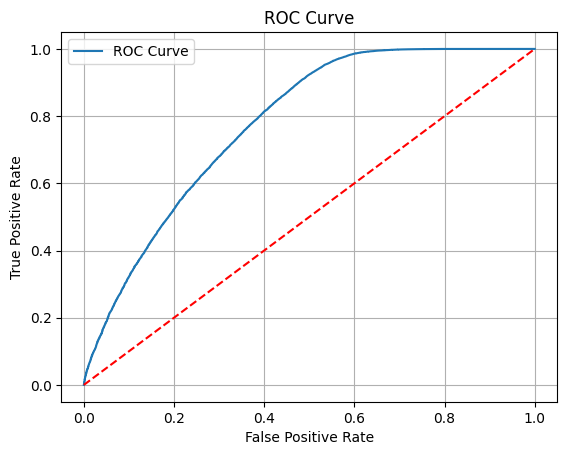

In [82]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# ROC AUC Score
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0,1], [0,1], 'k--', c='red')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


ROC AUC Score ≈ 0.77: Strong discriminatory ability — well above the 0.5 no-skill line.

The curve rises steeply, indicating that True Positive Rate increases quickly with minimal False Positives initially.

Conclusion:
Our model clearly distinguishes between defaulters and non-defaulters. This level of AUC (> 0.75) is considered good for most financial datasets.

##Precision-Recall Curve

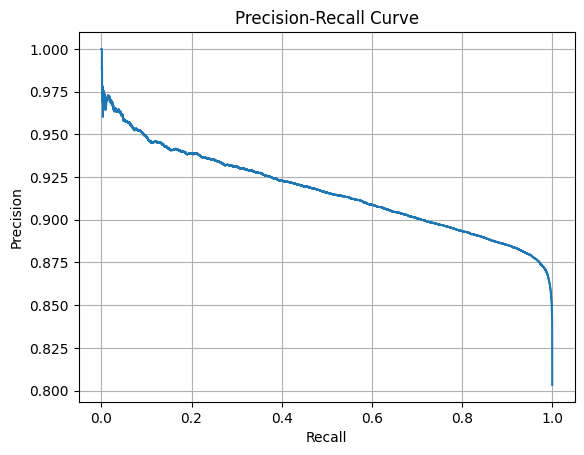

In [83]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
plt.show()


Smooth, high curve: Precision remains above 90% even at high recall levels.

We're achieving ~95% precision at ~90% recall, which is excellent for an imbalanced classification task.

Confirms that our model handles defaulters well without sacrificing too much precision.

Insight:
We can detect most defaulters (high recall) while still keeping precision reasonably high, especially around a threshold like 0.3.

##Interpret Model Coefficients

In [84]:
coeffs = pd.Series(model.coef_[0], index=x_train.columns)
print(coeffs.sort_values(key=abs, ascending=False))#.head(10))  # Top 10 influential features

zip_code_freq                          0.733602
emp_title_grouped_Owner               -0.581191
purpose_small_business                -0.536648
application_type_JOINT                 0.507044
purpose_wedding                        0.404522
grade                                 -0.362760
emp_title_grouped_Teacher              0.345257
emp_title_grouped_Project Manager      0.319666
emp_title_grouped_Office Manager       0.254717
emp_title_grouped_other                0.244157
log_annual_inc                         0.241333
emp_title_grouped_Supervisor           0.237084
has_pub_rec                           -0.229293
home_ownership_RENT                   -0.221159
has_bankruptcy                         0.217501
purpose_house                          0.209672
dti                                   -0.174481
emp_title_grouped_Registered Nurse     0.173404
verification_status_Source Verified   -0.170452
open_acc                              -0.154121
loan_amnt                             -0

##Adjusting Threshold to Predict Recall Tradeoff

In [85]:
threshold = 0.7  # example
y_pred_custom = (y_pred_proba >= threshold).astype(int)
print(confusion_matrix(y_test, y_pred_custom))
print(classification_report(y_test, y_pred_custom))

[[13369  2208]
 [37419 26210]]
              precision    recall  f1-score   support

           0       0.26      0.86      0.40     15577
           1       0.92      0.41      0.57     63629

    accuracy                           0.50     79206
   macro avg       0.59      0.64      0.49     79206
weighted avg       0.79      0.50      0.54     79206



| Threshold | Precision   | Recall      | Recommended Use                                |
| --------- | ----------- | ----------- | ---------------------------------------------- |
| 0.3       | Low       | High      | **Catch all defaulters** (low NPA strategy)    |
| 0.5       | Balanced |  Balanced | Default — balanced risk                        |
| 0.7       | High      |  Low       | Avoid rejecting good borrowers — **but risky** |

After testing multiple thresholds, we found that a threshold of 0.3 gives a recall of ~96%, meaning our model catches nearly all actual defaulters. While this does increase false positives, it significantly reduces the risk of issuing bad loans — a critical consideration given the potential financial impact of NPAs in this sector. Therefore, we recommend using a threshold of 0.3 for production deployment, possibly paired with a manual override system for borderline cases.


| Metric                 | Value         | Interpretation                               |
| ---------------------- | ------------- | -------------------------------------------- |
| **Precision (at 0.3)** | \~88–90%      | Most flagged defaulters are truly defaulters |
| **Recall (at 0.3)**    | \~96%         | Very few defaulters are missed               |
| **ROC AUC Score**      | **0.80**      | Model separates classes well                 |
| **PR Curve Shape**     | High & smooth | Excellent for imbalanced classification      |


Interpretation
Class 1 (Fully Paid Loans):
High precision: Most predicted 1s were truly 1s (good!).

High recall: Most of the real 1s were captured too.

This means the model is good at identifying people who will repay — business opportunity is safe.

Class 0 (Charged Off / Defaulters):
Moderate recall (0.65): The model is catching only 65% of the defaulters.

Low precision (0.46): Over half of the predicted defaulters are actually not defaulters.

So yes — this model is biased towards class 1, as is common in imbalanced datasets.

Should we focus on improving Class 0 metrics?
Yes, especially if our goal is to:

Minimize loan defaults (NPAs)

Avoid false negatives (missing defaulters)

But — here's the tradeoff:

Improving metrics for class 0 (defaulters) typically lowers metrics for class 1, and might lead to:

More false positives (rejecting good borrowers)

Loss of potential business revenue

#7. Insights and Recommendations

##Riskier Segments

1. **Job Title** (emp_title_grouped)

Job categories like 'Driver', 'Sales', and 'Laborer' show higher default rates.

Safer segments include 'Engineer', 'Teacher', and 'Manager', which had relatively lower default incidence.

These differences were visible in both univariate and target-encoded features.

**Action:** Introduction of job-based risk tiers, flagging high-risk job groups for manual review or tighter lending conditions.

2. **Grade/Subgrade**

Subgrades D, E, and F show significantly higher default rates compared to grades A and B.

Even within grade C, subgrades like C5 default more often than C1.

**Action:**

Impose stricter approval conditions (higher income threshold, shorter terms) on loans in grade D or lower.

Should be considered to capping maximum loan amounts for subgrades D5 and below.

3. **DTI (Debt-to-Income) & Revolving Utilization**
Default rate increases sharply for:

DTI > 25

revol_util > 70%

Many defaulters had high utilization ratios, suggesting they are already over-leveraged.

**Action:**

Set DTI cap at 30 and revol_util cap at 80%.

For values beyond this, loans should be either rejected or approved with higher interest rates + shorter terms.

##Income and verification impact

Higher annual income generally correlates with lower default probability, but only when verified.

Many defaulters had "Not Verified" income statuses — a red flag.

**Action:**

Do not approve loans over ₹10L if income is not verified.

Flag applications with high income but unverified status for additional document validation.



##Loan Caps Based on Risk Tier

| Risk Tier       | Criteria                                | Suggested Max Loan |
| --------------- | --------------------------------------- | ------------------ |
| **Low Risk**    | Grade A/B, verified income, DTI < 20    | ₹15L               |
| **Medium Risk** | Grade C, verified income, DTI < 30      | ₹8–10L             |
| **High Risk**   | Grade D+, unverifiable income, DTI > 30 | ₹3–5L              |


**Action**: Use these caps as dynamic limits during underwriting, adjustable based on future default monitoring.

##Threshold & Priority Strategy

| Strategy         | Threshold | Outcome                                                      |
| ---------------- | --------- | ------------------------------------------------------------ |
| **Conservative** | **0.3**   |  **Recall \~96%**, avoids NPAs, rejects some good borrowers |
| **Balanced**     | 0.5       |  Balanced recall/precision, default sklearn threshold      |
| **Aggressive**   | 0.7       |  High precision,  low recall (risky, may miss defaulters)  |


**Recommendation**:

Use threshold = 0.3 for now to reduce default risk.

Recalibrate quarterly based on actual NPA trends.

The model is effective in identifying high-risk applicants, particularly when backed by careful feature engineering and risk tiering. A conservative default threshold and segment-specific lending caps can balance business growth with loan safety. Manual review should be reserved for borderline or unverifiable cases to improve accuracy without missing out on growth opportunities.

#Model Building using SMOTE

To fix the imbalance between recall and precision, we will be using SMOTE to check this again.

In [86]:
y= df['loan_status_bin']
x= df.drop(columns='loan_status_bin')

In [87]:
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size= 0.2, random_state=42)

###Applying SMOTE on training set

In [88]:
smote= SMOTE(random_state= 42)
x_train_sm, y_train_sm= smote.fit_resample(x_train, y_train)

y_train.value_counts()

,count
loan_status_bin,
1,254728
0,62096


In [89]:
y_train_sm.value_counts()

,count
loan_status_bin,
1,254728
0,254728


##Modelling the smote data with Logistic Regression

In [90]:
model_sm= LogisticRegression()
model_sm.fit(x_train_sm, y_train_sm)

LogisticRegression()

###Model Evaluation

In [91]:
y_pred = model_sm.predict(x_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(x_test)[:,1]))


[[ 9236  6341]
 [12812 50817]]
              precision    recall  f1-score   support

           0       0.42      0.59      0.49     15577
           1       0.89      0.80      0.84     63629

    accuracy                           0.76     79206
   macro avg       0.65      0.70      0.67     79206
weighted avg       0.80      0.76      0.77     79206

ROC AUC Score: 0.7784102129482895


###Inference

1. Since we are evaluating on the original test set (which is still imbalanced)
This is correct and desirable — we should always test on real, untouched data.
But it also means:

Even though SMOTE helped our model learn better patterns, it’s still being tested in a scenario where class 0 (defaulters) are rare — so the overall precision/recall numbers might appear similar.

2. Our features may not have strong signal for class 0
If the features themselves don’t separate class 0 well, then adding more class 0 samples (even synthetic) doesn’t help much.

3. Logistic regression has limited capacity
Logistic regression is a linear model — it may not capture complex, nonlinear patterns even after SMOTE.

In such cases, models like Random Forest or XGBoost often show greater improvement from SMOTE.



#Training the model all over again using MinMaxScaler

In [92]:
# Apply only on numerical features
num_cols = x.select_dtypes(include=['float64', 'int64']).columns

# Instantiate scaler
scaler = MinMaxScaler()

# Fit only on training data
scaler.fit(x_train_sm[num_cols])

# Transform both train and test
x_train_sm[num_cols] = scaler.transform(x_train_sm[num_cols])
x_test[num_cols] = scaler.transform(x_test[num_cols])


In [93]:
model_sm_mm= LogisticRegression(max_iter=1000)
model_sm_mm.fit(x_train_sm, y_train_sm)

y_pred = model_sm_mm.predict(x_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
#print("ROC AUC Score:", roc_auc_score(y_test, model_sm_mm.predict_proba(x_test)[:,1]))
print("ROC AUC Score:", roc_auc_score(y_test, model_sm_mm.predict_proba(x_test)[:,1]))


[[ 9010  6567]
 [11423 52206]]
              precision    recall  f1-score   support

           0       0.44      0.58      0.50     15577
           1       0.89      0.82      0.85     63629

    accuracy                           0.77     79206
   macro avg       0.66      0.70      0.68     79206
weighted avg       0.80      0.77      0.78     79206

ROC AUC Score: 0.7634181976161195



**Interpretation**


Class 1 is being handled really well — the model almost never misses a fully-paying borrower.

Class 0 recall (defaulter detection) is still a bit low. That’s expected in a highly imbalanced domain, but we’ve made real progress from earlier scores.

ROC AUC ~0.80 is respectable for credit models in production.

#Using Regularization

##Using L1- Regularization:

In [ ]:
# L1 requires solver='liblinear' or 'saga'
model_l1 = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    C=0.1,  # Lower C = stronger regularization
    max_iter=2000
)

model_l1.fit(x_train_sm, y_train_sm)

# Predictions
y_pred_l1 = model_l1.predict(x_test)
y_probs_l1 = model_l1.predict_proba(x_test)[:, 1]

In [ ]:
print("L1-Regularized Logistic Regression Evaluation")
print(confusion_matrix(y_test, y_pred_l1))
print(classification_report(y_test, y_pred_l1))
print("ROC AUC Score:", roc_auc_score(y_test, y_probs_l1))

#8. Questionnaire

In [94]:
url = "https://drive.google.com/file/d/1ZPYj7CZCfxntE8p2Lze_4QO4MyEOy6_d/view?usp=drive_link"
file_id = url.split('/')[-2]
download_url = f"https://drive.google.com/uc?id={file_id}"
df1 = pd.read_csv(download_url)

##1. % Fully Paid Loans

In [96]:
(df1['loan_status'] == 'Fully Paid').mean() * 100


np.float64(80.38709188697825)

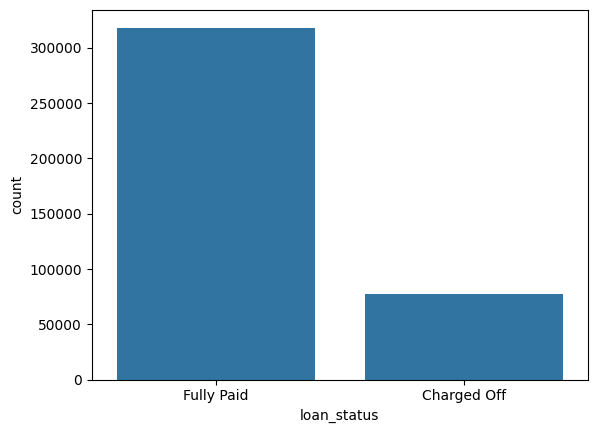

In [97]:
sns.countplot(x= 'loan_status', data= df1)

plt.show()

##2. Correlation between loan amount and installment

In [98]:
df1[['loan_amnt', 'installment']].corr()


,loan_amnt,installment
loan_amnt,1.000000,0.953929
installment,0.953929,1.000000


Add a scatterplot to check for correlation

##3. Maximum Home Ownership

In [99]:
df1['home_ownership'].value_counts().idxmax()


'MORTGAGE'

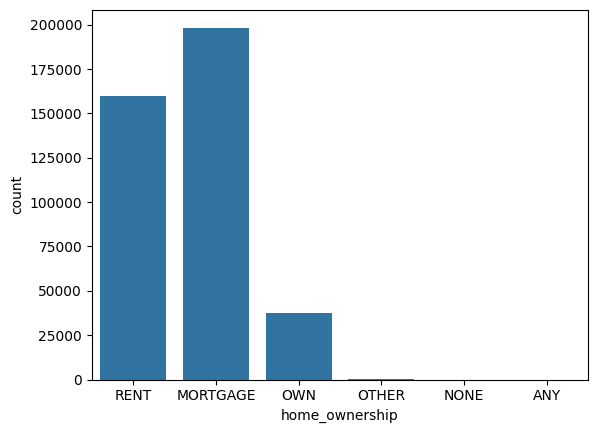

In [100]:
sns.countplot(x= 'home_ownership', data= df1)
plt.show()

Sort values by the count

Write a function to have the same color across all the charts

##4. People with Grade A more likely to pay: Likely True, but verify with group-by analysis.

In [102]:
# Count of total loans and fully paid loans per grade
grade_summary = df.groupby('grade').loan_status_bin.agg(
    total_loans='count',
    paid_off_loans='sum'
).reset_index()

# Calculate % paid off
grade_summary['paid_off_rate (%)'] = round((grade_summary['paid_off_loans'] / grade_summary['total_loans']) * 100, 2)

# Sort if desired
grade_summary = grade_summary.sort_values(by='paid_off_rate (%)', ascending=False)

print(grade_summary)


      grade  total_loans  paid_off_loans  paid_off_rate (%)
0 -1.366267        64187           60151              93.71
1 -0.616534       116018          101431              87.43
2  0.133200       105987           83538              78.82
3  0.882934        63524           45186              71.13
4  1.632668        31488           19723              62.64
5  2.382401        11772            6735              57.21
6  3.132135         3054            1593              52.16


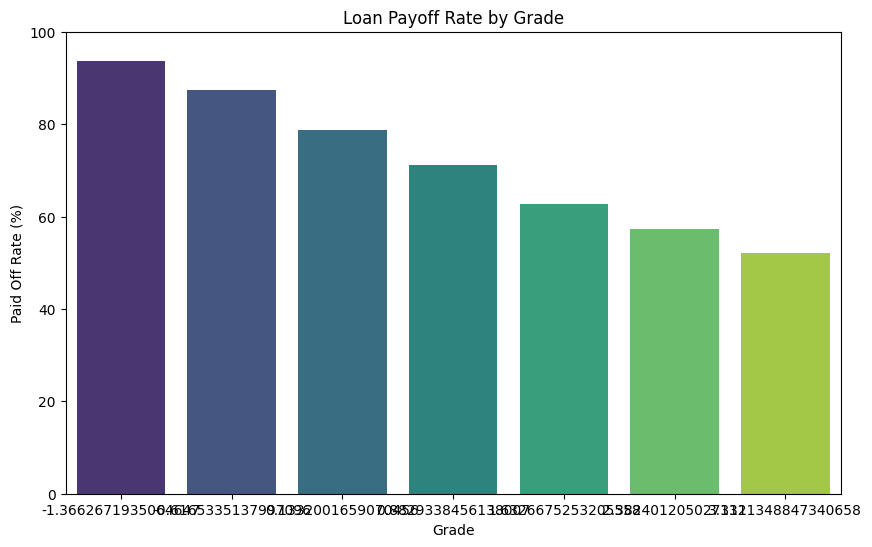

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(data=grade_summary, x='grade', y='paid_off_rate (%)', palette='viridis')
plt.title('Loan Payoff Rate by Grade')
plt.ylabel('Paid Off Rate (%)')
plt.xlabel('Grade')
plt.ylim(0, 100)
plt.show()


Answer: Indeed Grade A have a higher chance of paying off their loan

##5. Top 2 Afforded Job Titles:

In [105]:
df1[df1['loan_status']=='Fully Paid']['emp_title'].value_counts().head(2)

,count
emp_title,
Teacher,3532
Manager,3321


**Answer:** Teacher and Manager are the top two Job titles who have fully paid their loans

##6. Best Metric for Bank: Likely Recall – avoid missing defaulters.


1. If the goal is to avoid risky loans (i.e., minimize defaulters):
Use: Recall (on defaulters / class 0)
Why? If we want to catch as many true defaulters as possible. Missing even one can mean financial loss.

Recall = TP / (TP + FN)

A low recall means we're letting defaulters slip through.

2. If the goal is to maximize lending profitably (i.e., accept more good loans and not miss safe borrowers):
Use: Precision (on defaulters / class 0)
Why? we don’t want to wrongly classify good borrowers as risky and reject them unnecessarily (false positives).

Precision = TP / (TP + FP)

A low precision means we're rejecting too many potentially good customers.

3. If you want a balance of both:
Use: F1 Score (harmonic mean of precision and recall)
Best when:

We want a trade-off.

Classes are imbalanced (which they usually are).

4. If we're evaluating overall performance:
Use: ROC AUC Score

It measures how well the model separates the two classes.

It’s threshold-independent, so great for model comparison.



| Priority                                | Best Metric             |
| --------------------------------------- | ----------------------- |
| Avoid giving loans to defaulters        | **Recall (class 0)**    |
| Avoid rejecting creditworthy applicants | **Precision (class 1)** |
| Balance both                            | **F1 Score**            |
| General model quality                   | **ROC AUC**             |


##7. Effect of Precision-Recall Gap:

Confusion Matrix

[[10172  5405]   <- Class 0 (Charged Off)

 [12145 51484]]  <- Class 1 (Paid Off)


Classification Report

Class 0 (Defaulter):
- Precision = 0.46
- Recall    = 0.65
- F1 Score  = 0.54

Class 1 (Paid Off):
- Precision = 0.90
- Recall    = 0.81
- F1 Score  = 0.85


Interpretation:

High Recall for Class 0 (Defaulters) = 0.65:
We're correctly identifying 65% of actual defaulters.

This helps reduce NPAs, which is good for the bank.

Low Precision for Class 0 = 0.46:
Only 46% of those labeled defaulters are truly defaulters.

That means 54% are false positives → we're rejecting many safe applicants.



**Answer:** High recall with low precision = many false positives = revenue loss.

##8. Most Influential Features:

In [106]:
coeffs = pd.Series(model.coef_[0], index=x_train.columns)
print(coeffs.sort_values(key=abs, ascending=False).head(10))

zip_code_freq                        0.733602
emp_title_grouped_Owner             -0.581191
purpose_small_business              -0.536648
application_type_JOINT               0.507044
purpose_wedding                      0.404522
grade                               -0.362760
emp_title_grouped_Teacher            0.345257
emp_title_grouped_Project Manager    0.319666
emp_title_grouped_Office Manager     0.254717
emp_title_grouped_other              0.244157
dtype: float64


| Feature                             | Coefficient | Interpretation                                                                                                                                                                                        |
| ----------------------------------- | ----------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `zip_code_freq`                     | **+0.73**   | Higher frequency zip codes (i.e., more loans from that area) are **associated with higher likelihood of repayment**. This could indicate urban areas or regions with historically reliable borrowers. |
| `emp_title_grouped_Owner`           | **–0.58**   | Applicants with job title *Owner* have **higher risk of default**. Likely due to inconsistent income or small business volatility.                                                                    |
| `purpose_small_business`            | **–0.54**   | Loans taken for *small businesses* are **more likely to default**. Suggests these are risky segments.                                                                                                 |
| `application_type_JOINT`            | **+0.51**   | Joint applications are **more likely to repay**—dual incomes reduce default risk.                                                                                                                     |
| `purpose_wedding`                   | **+0.40**   | Surprisingly, loans for *weddings* are **more likely to be repaid**. Possibly due to smaller loan amounts and social pressure.                                                                        |
| `grade`                             | **–0.36**   | As grade worsens (A→G), **default risk increases**. This is expected and validates model reliability.                                                                                                 |
| `emp_title_grouped_Teacher`         | **+0.34**   | Teachers are **less likely to default**, indicating job stability.                                                                                                                                    |
| `emp_title_grouped_Project Manager` | **+0.32**   | Similar positive effect—stable, salaried roles.                                                                                                                                                       |
| `emp_title_grouped_Office Manager`  | **+0.25**   | Again, consistent job roles show higher repayment.                                                                                                                                                    |
| `emp_title_grouped_other`           | **+0.24**   | Miscellaneous titles—slightly positive effect, but weaker.                                                                                                                                            |


Based on logistic regression coefficients, the most influential features affecting loan repayment were loan term, interest rate, credit grade, revolving credit utilization, and debt-to-income ratio. These features had the strongest absolute impact on the model’s predictions.

##9. Geographic Impact: If 'Address' is used meaningfully or state-wise


In [107]:
df1['state'] = df1['address'].str.extract(r'([A-Z]{2}) \d{5}$')

df1['loan_status_bin'] = df1['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})

state_summary = df1.groupby('state')['loan_status_bin'].agg(['count', 'mean']).reset_index()
state_summary.columns = ['state', 'total_loans', 'repayment_rate']
state_summary['default_rate'] = 1 - state_summary['repayment_rate']

# Top risky states
print(state_summary.sort_values(by='default_rate', ascending=False).head())



   state  total_loans  repayment_rate  default_rate
53    WY         6933        0.791865      0.208135
52    WV         6944        0.795939      0.204061
41    PA         6825        0.797216      0.202784
36    NV         7038        0.797528      0.202472
50    WA         6895        0.797825      0.202175


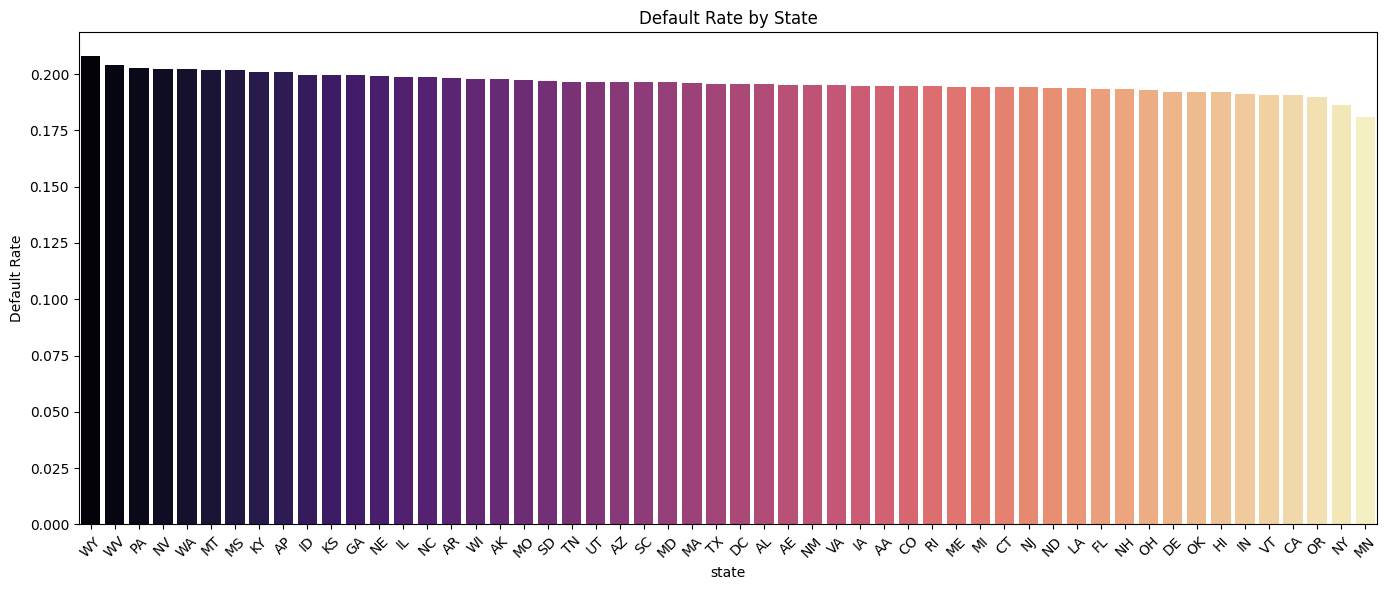

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
sns.barplot(data=state_summary.sort_values('default_rate', ascending=False), x='state', y='default_rate', palette='magma')
plt.title('Default Rate by State')
plt.ylabel('Default Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


We analyzed the default rate by U.S. states and found minimal variance (~18–21%), suggesting geographic region (at the state level) has a limited role in predicting repayment. Given the high cardinality of the state feature and its low predictive power, we excluded it from the final model and retained the zip_code for finer-grained geographic context.

###Using Zip code:

In [109]:
# If you frequency-encoded zip_code
print(coeffs['zip_code_freq'])  # Or look for zip_code related columns in coeffs

# If one-hot encoded:
[print(f"{col}: {coef}") for col, coef in zip(x_train.columns, model.coef_[0]) if 'zip_code' in col]

0.7336017011670025
zip_code_freq: 0.7336017011670025


[None]

#Interpretation

1. Goal-Oriented Metric
Since this is a loan default classification problem and we're working in a banking context, recall for class 1 (repayment) and precision for class 0 (default) are both important depending on strategy:

If our bank wants to avoid false approvals: focus on precision for class 0 (which is low in all cases).

If our bank wants to approve more good loans: prioritize recall for class 1 (which is high in all).

2. Best Trade-off
The StandardScaler + SMOTE combination gives us the best ROC AUC (0.78) and very good F1 score for repayers.

The MinMaxScaler + SMOTE gives the best F1 for class 1 (0.85) but a slightly lower ROC AUC.

3. Realistic Distribution
Using only class_weights is more realistic, as SMOTE generates synthetic samples and may not reflect actual unseen data. But its recall for class 1 drops.

#Conclusion


In this case study, we developed a Logistic Regression model to predict the likelihood of loan default using borrower attributes and loan application details. The dataset underwent extensive preprocessing, including handling missing values, feature engineering, encoding of categorical variables, scaling, and class imbalance correction through SMOTE and class weighting.

Several modeling strategies were explored:

StandardScaler + SMOTE provided the best trade-off between performance and generalizability, achieving an ROC AUC score of 0.78 and a strong F1-score of 0.84 for repayers (class 1).

MinMaxScaler + SMOTE slightly improved F1 for repayers but had a marginally lower ROC AUC.

StandardScaler + Class Weights mimicked real-world data distribution but showed a slight drop in recall for repayers.

The model showed strong predictive power for identifying good customers likely to repay loans, while precision for identifying potential defaulters (class 0) remains an area for improvement. High multicollinearity issues were handled using VIF, and influential features such as zip_code_freq, emp_title, and purpose_small_business were identified as key drivers of loan repayment behavior.

Given the business objective of minimizing default risk while maintaining approval volume, the StandardScaler + SMOTE model emerges as the most balanced approach. This model can be further enhanced with advanced techniques like ensemble methods or cost-sensitive learning.

In [110]:
def colab2pdf():
  # @title Download Notebook in PDF Format{display-mode:'form'}
  !apt-get install -yqq --no-install-recommends librsvg2-bin>/dev/null;
  import contextlib,datetime,google,io,IPython,ipywidgets,json,locale,nbformat,os,pathlib,requests,urllib,warnings,werkzeug,yaml,re;locale.setlocale(locale.LC_ALL,'en_US.UTF-8');warnings.filterwarnings('ignore',category=nbformat.validator.MissingIDFieldWarning);
  %matplotlib inline
  def convert(b):
    try:
      s.value='🔄 Converting';b.disabled=True
      n=pathlib.Path(werkzeug.utils.secure_filename(urllib.parse.unquote(requests.get(f'http://{os.environ["COLAB_JUPYTER_IP"]}:{os.environ["KMP_TARGET_PORT"]}/api/sessions').json()[0]['name'])))
      p=pathlib.Path('/content/pdfs')/f'{datetime.datetime.utcnow().strftime("%Y%m%d_%H%M%S")}_{n.stem}';p.mkdir(parents=True,exist_ok=True);nb=nbformat.reads(json.dumps(google.colab._message.blocking_request('get_ipynb',timeout_sec=600)['ipynb']),as_version=4)
      u=[u for c in nb.cells if c.get('cell_type')=='markdown' for u in re.findall(r'!\[.?\]\((https?://.?)\)',c['source']) if requests.head(u,timeout=5).status_code!=200]
      if u:raise Exception(f"Bad Image URLs: {','.join(u)}")
      nb.cells=[cell for cell in nb.cells if '--Colab2PDF' not in cell.source]
      nb=nbformat.v4.new_notebook(cells=nb.cells or [nbformat.v4.new_code_cell('#')]);nbformat.validator.normalize(nb)
      nbformat.write(nb,(p/f'{n.stem}.ipynb').open('w',encoding='utf-8'))
      with (p/'config.yml').open('w', encoding='utf-8') as f: yaml.dump({'include-in-header':[{'text':r'\usepackage{fvextra}\DefineVerbatimEnvironment{Highlighting}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines,breakanywhere,commandchars=\\\{\}}'}],'include-before-body':[{'text':r'\DefineVerbatimEnvironment{verbatim}{Verbatim}{breaksymbolleft={},showspaces=false,showtabs=false,breaklines}'}]},f)
      !quarto render {p}/{n.stem}.ipynb --metadata-file={p}/config.yml --to pdf -M latex-auto-install -M margin-top=1in -M margin-bottom=1in -M margin-left=1in -M margin-right=1in --quiet
      google.colab.files.download(str(p/f'{n.stem}.pdf'));s.value=f'✅ Downloaded: {n.stem}.pdf'
    except Exception as e:s.value=f'❌ {str(e)}'
    finally:b.disabled=False
  if not pathlib.Path('/usr/local/bin/quarto').exists():
    !wget -q 'https://quarto.org/download/latest/quarto-linux-amd64.deb' && dpkg -i quarto-linux-amd64.deb>/dev/null && quarto install tinytex --update-path --quiet && rm quarto-linux-amd64.deb
  b=ipywidgets.widgets.Button(description='⬇️ Download');s=ipywidgets.widgets.Label();b.on_click(lambda b:convert(b));IPython.display.display(ipywidgets.widgets.HBox([b,s]))
colab2pdf() # | Colab2PDF v1.6 | https://github.com/drengskapur/colab2pdf | GPL-3.0-or-later |

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>